In [2]:
import pandas as pd
import numpy as np
import cv2, os
import glob
import matplotlib.pyplot as plt
import pathlib
import shutil
from sklearn.model_selection import train_test_split
import pathlib


In [5]:
def normalize_keypoints(keypoints, width, height):
    normalized_keypoints = []
    for x, y in keypoints:
        x_norm = x / width
        y_norm = y / height
        normalized_keypoints.append([x_norm, y_norm])
    return normalized_keypoints


def xyxy_to_xywh_normalized(xyxy_bbox, image_width, image_height):
    x_min, y_min, x_max, y_max = xyxy_bbox
    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + width / 2
    y_center = y_min + height / 2

    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = width / image_width
    height_normalized = height / image_height

    return x_center_normalized, y_center_normalized, width_normalized, height_normalized


def keypoints_to_bbox(keypoints):
    x_coordinates = [point[0] for point in keypoints]
    y_coordinates = [point[1] for point in keypoints]

    x_min = min(x_coordinates)
    y_min = min(y_coordinates)
    x_max = max(x_coordinates)
    y_max = max(y_coordinates)
    return x_min, y_min, x_max, y_max


def show_polygons(dir_image, url, points):
    image = cv2.imread(os.path.join(dir_image, os.path.basename(url)))
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 1, 2))
    image = cv2.polylines(image, [pts], True, (0,255,255), 5)

    plt.imshow(image)
    plt.show()


def show_bounding_box(dir_image, url, bboxes):
    image = cv2.imread(os.path.join(dir_image, os.path.basename(url)))
    start_pt = (int(bboxes[0]), int(bboxes[1]))
    end_pt = (int(bboxes[2]), int(bboxes[3]))

    print(start_pt)
    print(end_pt)

    image = cv2.rectangle(image, start_pt, end_pt, (0, 255, 0), 2) 
    plt.imshow(image)
    plt.show()


def move_file(source_folder, destination_folder, file_name):
    # Check if the source file exists
    source_path = os.path.join(source_folder, file_name)
    if not os.path.exists(source_path):
        print(f"Source: {source_path}, file '{file_name}' not found in '{source_folder}'.")
        return
    
    # Check if the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder, exist_ok=True)  # Create the destination folder if it doesn't exist
    
    # Construct the destination path
    destination_path = os.path.join(destination_folder, file_name)
    
    try:
        shutil.move(source_path, destination_path)
        print(f"File '{file_name}' moved from '{source_folder}' to '{destination_folder}'.")
    except Exception as e:
        print(f"Failed to move the file: {e}")



In [ ]:
root = "/home/fit/optivisionlab/scan-bill/bill_printed"
dires = os.listdir(root)
for dir in dires:
    print(dir)
    os.makedirs(os.path.join(root, dir, "label_txt"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "label_json"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "images"), exist_ok=True)
    os.system(f"mv {os.path.join(root, dir, '*.json')} {os.path.join(root, dir, 'label_json')}")
    os.system(f"mv {os.path.join(root, dir, '*.jpg')} {os.path.join(root, dir, 'images')}")
    files_json = glob.glob(os.path.join(root, dir, "label_json/*"))
    for file in files_json:
        print("file >>> ", file)
        _, _, label, file_name, _, imageHeight, imageWidth = pd.read_json(file, orient='index').values
        keyptsn = normalize_keypoints(keypoints=np.array(label[0][0]['points']), width=imageWidth[0], height=imageHeight[0])
        boxes = keypoints_to_bbox(keypoints=np.array(label[0][0]['points']))
        xywhn = xyxy_to_xywh_normalized(xyxy_bbox=boxes, image_width=imageWidth[0], image_height=imageHeight[0])
        line = (0, *xywhn, *keyptsn[0], *keyptsn[1], *keyptsn[2], *keyptsn[3])
        with open(os.path.join(root, dir, 'label_txt', pathlib.Path(file_name[0]).stem + '.txt'), 'w') as f:
            f.write(('%g ' * len(line)).rstrip() % line + '\n')

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/bill_printed"
dires = os.listdir(root)
for dir in dires:
    files = glob.glob(os.path.join(root, dir, "images/*.jpg"))
    print(dir, len(files))
    if len(files) > 10:
        print("process >>>>>> ", dir, len(files))
        train, val= train_test_split(files, test_size=0.3, random_state=1000, shuffle=True)
        print(len(train), len(val))

        os.makedirs(os.path.join(root, dir, "images/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "images/val"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "labels/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "labels/val"), exist_ok=True)

        for file in train:
                move_file(source_folder=os.path.join(root, dir, "images"), 
                        destination_folder=os.path.join(root, dir, "images/train"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "label_txt"), 
                        destination_folder=os.path.join(root, dir, "labels/train"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )
        
        for file in val:
                move_file(source_folder=os.path.join(root, dir, "images"), 
                        destination_folder=os.path.join(root, dir, "images/val"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "label_txt"), 
                        destination_folder=os.path.join(root, dir, "labels/val"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )


# Xử lý gom keypoint bill

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/bill_printed"
dires = os.listdir(root)
for dir in dires:
    files = glob.glob(os.path.join(root, dir, "images/*.jpg"))
    print(dir, len(files))
    if len(files) > 10:
        print("process >>>>>> ", dir, len(files))


In [3]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)

cntTrain_img, cntVal_img = 0, 0
cntTrain_lb, cntVal_lb = 0, 0
for dir in dires:
    if dir == "small-data":
        continue
    
    cntTrain_img += len(os.listdir(os.path.join(root, dir, 'images', 'train')))
    cntVal_img += len(os.listdir(os.path.join(root, dir, 'images', 'val')))
    cntTrain_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'train')))
    cntVal_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'val')))

cntTrain_img, cntVal_img, cntTrain_lb, cntVal_lb

(5650, 2429, 5642, 2424)

In [4]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)
target_dir = "/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks"
cntTrain_img, cntVal_img = 0, 0
cntTrain_lb, cntVal_lb = 0, 0
for dir in dires:
    if dir == "small-data":
        continue
    
    shutil.copytree(os.path.join(root, dir, 'images', 'train'), os.path.join(target_dir, 'images', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'images', 'val'), os.path.join(target_dir, 'images', 'val'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'labels', 'train'), os.path.join(target_dir, 'labels', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'labels', 'val'), os.path.join(target_dir, 'labels', 'val'), dirs_exist_ok=True)

    # cntTrain_img += len(os.listdir(os.path.join(root, dir, 'images', 'train')))
    # cntVal_img += len(os.listdir(os.path.join(root, dir, 'images', 'val')))
    # cntTrain_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'train')))
    # cntVal_lb += len(os.listdir(os.path.join(root, dir, 'labels', 'val')))


In [5]:
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/images/train")))
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/images/val")))
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/labels/train")))
print(len(os.listdir("/home/fit/optivisionlab/scan-bill/dataset/bill_keypoint_landmarks/labels/val")))

5650
2429
5642
2424


# Xử lý phần dữ liệu keypoint tiền

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)
for dir in dires:
    print(dir)
    os.makedirs(os.path.join(root, dir, 'image_warped', "label_txt"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, 'image_warped', "label_json"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, 'image_warped', "images"), exist_ok=True)
    os.system(f"mv {os.path.join(root, dir, 'image_warped', '*.json')} {os.path.join(root, dir, 'image_warped', 'label_json')}")
    os.system(f"mv {os.path.join(root, dir, 'image_warped', '*.jpg')} {os.path.join(root, dir, 'image_warped', 'images')}")
    files_json = glob.glob(os.path.join(root, dir, 'image_warped', "label_json/*"))
    for file in files_json:
        print("file >>> ", file)
        _, _, label, file_name, _, imageHeight, imageWidth = pd.read_json(file, orient='index').values
        keyptsn = normalize_keypoints(keypoints=np.array(label[0][0]['points']), width=imageWidth[0], height=imageHeight[0])
        boxes = keypoints_to_bbox(keypoints=np.array(label[0][0]['points']))
        xywhn = xyxy_to_xywh_normalized(xyxy_bbox=boxes, image_width=imageWidth[0], image_height=imageHeight[0])
        line = (0, *xywhn, *keyptsn[0], *keyptsn[1], *keyptsn[2], *keyptsn[3])
        with open(os.path.join(root, dir, 'image_warped', 'label_txt', pathlib.Path(file_name[0]).stem + '.txt'), 'w') as f:
            f.write(('%g ' * len(line)).rstrip() % line + '\n')

In [ ]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
dires = os.listdir(root)
for dir in dires:
    files = glob.glob(os.path.join(root, dir, "image_warped/images/*.jpg"))
    print(dir, len(files))
    if len(files) > 10:
        print("process >>>>>> ", dir, len(files))
        train, val= train_test_split(files, test_size=0.3, random_state=1000, shuffle=True)
        print(len(train), len(val))

        os.makedirs(os.path.join(root, dir, "image_warped/images/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "image_warped/images/val"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "image_warped/labels/train"), exist_ok=True)
        os.makedirs(os.path.join(root, dir, "image_warped/labels/val"), exist_ok=True)

        for file in train:
                move_file(source_folder=os.path.join(root, dir, "image_warped/images"), 
                        destination_folder=os.path.join(root, dir, "image_warped/images/train"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "image_warped/label_txt"), 
                        destination_folder=os.path.join(root, dir, "image_warped/labels/train"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )
        
        for file in val:
                move_file(source_folder=os.path.join(root, dir, "image_warped/images"), 
                        destination_folder=os.path.join(root, dir, "image_warped/images/val"), 
                        file_name=os.path.basename(file)
                        )
                move_file(source_folder=os.path.join(root, dir, "image_warped/label_txt"), 
                        destination_folder=os.path.join(root, dir, "image_warped/labels/val"), 
                        file_name=pathlib.Path(os.path.basename(file)).stem + '.txt'
                        )


In [8]:
root = "/home/fit/optivisionlab/scan-bill/dataset/bill_printed_temp"
target_dir = "/home/fit/optivisionlab/scan-bill/dataset/money_keypoint_landmarks"
dires = os.listdir(root)
for dir in dires:
    os.makedirs(os.path.join(root, dir), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(root, dir, "labels/val"), exist_ok=True)

    shutil.copytree(os.path.join(root, dir, 'image_warped', 'images', 'train'), os.path.join(target_dir, dir, 'images', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'image_warped', 'images', 'val'), os.path.join(target_dir, dir, 'images', 'val'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'image_warped', 'labels', 'train'), os.path.join(target_dir, dir, 'labels', 'train'), dirs_exist_ok=True)
    shutil.copytree(os.path.join(root, dir, 'image_warped', 'labels', 'val'), os.path.join(target_dir, dir, 'labels', 'val'), dirs_exist_ok=True)

# Test infer

In [59]:
from ultralytics import YOLO
import cv2
import imutils
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import os


#function to order points to proper rectangle
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


#function to transform image to four points
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)

    # # multiply the rectangle by the original ratio
    # rect *= ratio

    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


#function to find two largest countours which ones are may be
#  full image and our rectangle edged object
def findLargestCountours(cntList, cntWidths):
    newCntList = []
    newCntWidths = []

    #finding 1st largest rectangle
    first_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[first_largest_cnt_pos])
    newCntWidths.append(cntWidths[first_largest_cnt_pos])

    #removing it from old
    cntList.pop(first_largest_cnt_pos)
    cntWidths.pop(first_largest_cnt_pos)

    #finding second largest rectangle
    seccond_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[seccond_largest_cnt_pos])
    newCntWidths.append(cntWidths[seccond_largest_cnt_pos])

    #removing it from old
    cntList.pop(seccond_largest_cnt_pos)
    cntWidths.pop(seccond_largest_cnt_pos)

    print('Old Screen Dimentions filtered', cntWidths)
    print('Screen Dimentions filtered', newCntWidths)
    return newCntList, newCntWidths


#driver function which identifieng 4 corners and doing four point transformation
def convert_object(image, screen_size = None, isDebug = False):

    # image = imutils.resize(image, height=300)
    # ratio = image.shape[0] / 300.0


    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)  # 11  //TODO 11 FRO OFFLINE MAY NEED TO TUNE TO 5 FOR ONLINE

    gray = cv2.medianBlur(gray, 5)
    edged = cv2.Canny(gray, 30, 400)

    if isDebug:
        cv2.imshow('edged', edged)
        # cv2_imshow(edged)
    # find contours in the edged image, keep only the largest
    # ones, and initialize our screen contour

    countours, hierarcy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    if isDebug : print('length of countours ', len(countours))

    imageCopy = image.copy()
    if isDebug:
        cv2.imshow('drawn countours', cv2.drawContours(imageCopy, countours, -1, (0, 255, 0), 1))
        print('drawn countours')
        # cv2_imshow(cv2.drawContours(imageCopy, countours, -1, (0, 255, 0), 1))


    # approximate the contour
    cnts = sorted(countours, key=cv2.contourArea, reverse=True)
    screenCntList = []
    scrWidths = []
    for cnt in cnts:
        peri = cv2.arcLength(cnt, True)  # cnts[1] always rectangle O.o
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        screenCnt = approx
        # print(len(approx))

        if (len(screenCnt) == 4):

            (X, Y, W, H) = cv2.boundingRect(cnt)
            # print('X Y W H', (X, Y, W, H))
            screenCntList.append(screenCnt)
            scrWidths.append(W)

        # else:
        #     print("4 points not found")

    print('Screens found :', len(screenCntList))
    print('Screen Dimentions', scrWidths)

    screenCntList, scrWidths = findLargestCountours(screenCntList, scrWidths)

    if not len(screenCntList) >=2: #there is no rectangle found
        return None
    elif scrWidths[0] != scrWidths[1]: #mismatch in rect
        return None

    if isDebug:
        cv2.imshow(" Screen", cv2.drawContours(image.copy(), [screenCntList[0]], -1, (0, 255, 0), 3))
        print("Screen")
        # cv2_imshow(cv2.drawContours(image.copy(), [screenCntList[0]], -1, (0, 255, 0), 3))

    # now that we have our screen contour, we need to determine
    # the top-left, top-right, bottom-right, and bottom-left
    # points so that we can later warp the image -- we'll start
    # by reshaping our contour to be our finals and initializing
    # our output rectangle in top-left, top-right, bottom-right,
    # and bottom-left order
    pts = screenCntList[0].reshape(4, 2)
    print('Found bill rectagle at ', pts)
    rect = order_points(pts)
    print(rect)

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, pts)

    # convert the warped image to grayscale and then adjust
    # the intensity of the pixels to have minimum and maximum
    # values of 0 and 255, respectively
    warp = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warp = exposure.rescale_intensity(warp, out_range=(0, 255))

    # show the original and warped images
    if(isDebug):
        cv2.imshow("Original", image)
        cv2.imshow("warp", warp)
        cv2.waitKey(0)

    if(screen_size != None):
        return cv2.cvtColor(cv2.resize(warp, screen_size), cv2.COLOR_GRAY2RGB)
    else:
        return cv2.cvtColor(warp, cv2.COLOR_GRAY2RGB)
    

def image_warped_transform(image, keypoint, save_folder=None, save=False, show=False, rescale_intensity=False):
    # image = cv2.imread(image_path)
    keypointx = np.array(keypoint, dtype = "float32")
    keypointx = keypointx.reshape(4, 1, 2)
    print(cv2.isContourConvex(keypointx))
    warped = four_point_transform(image, np.array(keypoint, dtype = "float32"))
    if rescale_intensity:
        warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
        warped = exposure.rescale_intensity(warped, out_range=(0, 255))
    # if save:
    #     cv2.imwrite(os.path.join(save_folder, os.path.basename(image_path)), warped)
    #     return warped, os.path.join(save_folder, os.path.basename(image_path))
    # if show:
    #     plt.imshow(image)
    #     plt.show()
    #     plt.imshow(warped)
    #     plt.show()
    return warped


def ultra_keypoints(inputs):
    '''
    input: results by ultralytics (only one image)
    output:
        conf: float
        boxes: [xmin, ymin, xmax, ymax]
        keypoints: [[x,y], [x,y], [x,y], [x,y]] max 4 keypoint
    '''
    confident = None
    boxes = None
    keypoints = None
    for result in inputs:
        confident = result.boxes.conf.cpu().numpy()
        boxes = result.boxes.xyxy.cpu().numpy()  # Boxes object for bbox outputs
        keypoints = result.keypoints.xy.cpu().numpy()  # Keypoints object for pose outputs
    if len(confident) == 0:
        return False, None, None, None
    best_idx = np.argmax(confident)
    return True, confident[best_idx], boxes[best_idx], keypoints[best_idx]


def ultra_model_load(weights_path):
    model = YOLO(weights_path)
    return model



In [67]:
from paddleocr import PaddleOCR


smart_banking = ['agribank', 'vcb', 'bidv', 'LP', 'viettel_money', 'ocb', 'tcb', 'vtb', 'mb', 'vib_ver2', 'acb', 'tp', 'vpbank', 'msb']
money_keypts_infer_list = {}
ppocr_infer = PaddleOCR(
    use_angle_cls=True, use_gpu=True, 
    det_model_dir="/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer",
    rec_model_dir="/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer",
    cls_model_dir="/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer"
)
print("load model  ppocr_infer done!")

bill_keypts_infer = ultra_model_load(weights_path="/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/bill/bill-yolov8s-pose-best.pt")
print("load model  bill_keypts_infer done!")

for bank in smart_banking:
    money_keypts_infer = ultra_model_load(weights_path=f"/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/smart-banking/{bank}/{bank}-yolov8s-pose-best.pt")
    money_keypts_infer_list[bank] = money_keypts_infer
    print(f"load model {bank}  money_infer done!")


[2024/05/04 17:59:53] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/data-gpu/quangdm2/OptiVisionLab/scan-bill/weights/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True

In [68]:
def scan_bill(source, infer_weights):
    ppocr_infer, bill_infer, money_infer = infer_weights
    image_bill = cv2.imread(source)
    results_bill = bill_infer.predict(image_bill, save=False, conf=0.7, iou=0.7, imgsz=640)
    _, _, _, bill_keypts = ultra_keypoints(results_bill)
    bill_imagew = image_warped_transform(image=image_bill, keypoint=bill_keypts, save_folder=None, save=False, show=False, rescale_intensity=False)
    results_money = money_infer.predict(bill_imagew, save=True, conf=0.7, iou=0.7, imgsz=640)
    _, _, _, money_keypts = ultra_keypoints(results_money)
    money_imagew = image_warped_transform(image=bill_imagew, keypoint=money_keypts, save_folder=None, save=False, show=False, rescale_intensity=False)
    text = ppocr_infer.ocr(money_imagew, rec=True, cls=True, det=False)[0]
    return text[0][0], text[0][1]

In [ ]:
import gradio as gr

def demo_scan_bill(image, smart_banking):
    temp_dir_input = "/data-gpu/quangdm2/OptiVisionLab/scan-bill/runs"
    save_path_input = os.path.join(temp_dir_input, "demo.jpg")
    cv2.imwrite(save_path_input, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    infer_weights = (ppocr_infer, bill_keypts_infer, money_keypts_infer_list[smart_banking])
    text_money, text_conf = scan_bill(source=save_path_input, infer_weights=infer_weights)
    return f"AI: Độ tin cậy = {round((float(text_conf) * 100), 3)}%  ======  Số Tiền = {text_money}"

# def test(image, smart_banking):
#     print(smart_banking)
#     return "test"

demo = gr.Interface(fn=demo_scan_bill,
    inputs=[
        "image", 
        gr.Dropdown(
            smart_banking, label="Ngân Hàng", info="Chọn một trong các ngân hàng sau"
        )
    ], 
    outputs="textbox",
    examples=[
        ["/data-gpu/quangdm2/OptiVisionLab/scan-bill/src/assets/data.jpg", "vcb"],
        ["/data-gpu/quangdm2/OptiVisionLab/scan-bill/src/assets/data2.png", "bidv"],
    ]
    )
    

demo.launch(share=True, debug=True) 

In [51]:

image_bill = cv2.imread("/data-gpu/quangdm2/OptiVisionLab/scan-bill/src/assets/data2.png")
results_bill = bill_infer.predict(image_bill, save=False, conf=0.7, iou=0.7, imgsz=640)
_, _, _, bill_keypts = ultra_keypoints(results_bill)
bill_imagew = image_warped_transform(image=image_bill, keypoint=bill_keypts, save_folder=None, save=False, show=False, rescale_intensity=False)
results_money = money_infer.predict(bill_imagew, save=True, conf=0.7, iou=0.7, imgsz=640)
_, _, _, money_keypts = ultra_keypoints(results_money)
money_imagew = image_warped_transform(image=bill_imagew, keypoint=money_keypts, save_folder=None, save=False, show=False, rescale_intensity=False)
text = ppocr_infer.ocr(money_imagew, rec=True, cls=True, det=False)[0]


0: 640x480 1 bill, 7.9ms
Speed: 5.2ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)



True


0: 640x352 1 money, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)
Results saved to runs/pose/predict3


True


In [55]:
import pandas as pd

df = pd.read_csv("/data-gpu/quangdm2/OptiVisionLab/runs/bill_printed/money_bankes.csv") # scb, bank_mix
df

,Bank,Box_mAP50,Box_mAP75,Box_mAP(50-95),Pose_mAP50,Pose_mAP75,Pose_mAP(50-95)
0,agribank,0.946700,0.924525,0.747210,0.946700,0.946700,0.945091
1,vcb,0.994850,0.987687,0.829237,0.994850,0.994850,0.994850
2,bidv,0.995000,0.985261,0.753204,0.995000,0.995000,0.995000
3,LP,0.936100,0.936100,0.750235,0.936100,0.936100,0.923840
4,viettel_money,0.972000,0.892082,0.729752,0.972000,0.940906,0.940297
5,ocb,0.987900,0.970420,0.815191,0.987900,0.987900,0.987286
6,tcb,0.995000,0.977415,0.826797,0.995000,0.988341,0.988810
7,scb,0.690469,0.519094,0.458356,0.690469,0.690469,0.582217
8,vtb,0.995000,0.963450,0.749427,0.995000,0.995000,0.994983
9,bank_mix,0.950000,0.888333,0.667639,0.950000,0.950000,0.770215


In [57]:
df['Bank'].values
# ['agribank', 'vcb', 'bidv', 'LP', 'viettel_money', 'ocb', 'tcb', 'vtb', 'mb', 'vib_ver2', 'acb', 'tp', 'vpbank', 'msb']

array(['agribank', 'vcb', 'bidv', 'LP', 'viettel_money', 'ocb', 'tcb', 'scb', 'vtb', 'bank_mix', 'mb', 'vib_ver2', 'acb', 'tp', 'vpbank', 'msb'], dtype=object)

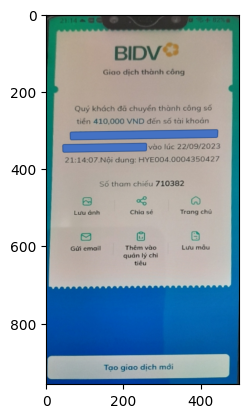

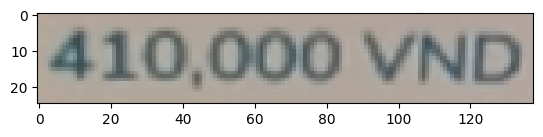

In [47]:
import matplotlib.pyplot as plt

# image = cv2.imread(imagew_path)
plt.imshow(cv2.cvtColor(bill_imagew, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(money_imagew, cv2.COLOR_BGR2RGB))
plt.show()